
# Portfolio Analysis & Rebalancing Tool (S&P 500 Subset)

This notebook builds a small, modular framework to:
- Download prices for a subset of S&P 500 stocks (here: **NVDA, MSFT, AAPL, AMZN, GOOGL**) and SPY as a benchmark.
- Compute daily returns and portfolio risk/return metrics.
- Implement **Equal-Weight** and **Minimum-Variance** rebalancing strategies (monthly).
- Backtest both approaches, export results (CSV) and plot key figures.

> Notes
> - Long-only, fully invested, sum of weights = 1.
> - Simple transaction costs model based on weight change.
> - Covariance is estimated on a rolling lookback window — consider shrinkage if you extend this.


In [25]:

# If needed, install dependencies in your environment
# (Uncomment if you're running this in a new environment)
# %pip install pandas numpy yfinance cvxpy matplotlib


In [26]:

from __future__ import annotations

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import yfinance as yf

# Optional: silence warnings from cvxpy solvers
import warnings
warnings.filterwarnings("ignore")


## Data Utilities

In [27]:

from datetime import datetime

def fetch_prices(tickers: list[str], start: str = "2015-01-01", end: str = None,
                 cache_dir: str = "data") -> pd.DataFrame:
    """
    Download adjusted-close daily prices using yfinance, with simple local caching (parquet).
    Returns a DataFrame (Date index, tickers as columns) of prices.
    """
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)
    end = end or datetime.today().strftime("%Y-%m-%d")
    cache_path = cache_dir / f"adjclose_{'_'.join(tickers)}_{start}_{end}.parquet"
    if cache_path.exists():
        return pd.read_parquet(cache_path)

    data = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
    if isinstance(data, pd.Series):
        data = data.to_frame()
    data = data.sort_index().ffill().dropna(how="all")
    data.to_parquet(cache_path)
    return data

def sp500_proxy(start: str = "2015-01-01", end: str = None) -> pd.Series:
    """
    Use SPY ETF as a proxy for S&P 500 (benchmark).
    Returns a price series.
    """
    px = yf.download("SPY", start=start, end=end, auto_adjust=True, progress=False)["Close"]
    return px.dropna().sort_index()


## Metrics & Helpers

In [28]:

def to_returns(prices: pd.DataFrame) -> pd.DataFrame:
    return prices.pct_change().dropna(how="all")

def annualize_return(daily_returns: pd.Series, periods_per_year: int = 252) -> float:
    cum = (1 + daily_returns).prod()
    n = len(daily_returns)
    return cum ** (periods_per_year / n) - 1 if n > 0 else np.nan

def annualize_vol(daily_returns: pd.Series, periods_per_year: int = 252) -> float:
    return daily_returns.std(ddof=0) * np.sqrt(periods_per_year)

def sharpe(daily_returns: pd.Series, rf_daily: float = 0.0) -> float:
    excess = daily_returns - rf_daily
    vol = excess.std(ddof=0)
    return (excess.mean() / vol) * np.sqrt(252) if float(vol) > 0 else np.nan

def max_drawdown(equity_curve: pd.Series) -> float:
    running_max = equity_curve.cummax()
    drawdown = equity_curve / running_max - 1.0
    return drawdown.min()

def summarize_portfolio(daily_portfolio_returns: pd.Series) -> dict:
    eq = (1 + daily_portfolio_returns).cumprod()
    return {
        "ann_return": annualize_return(daily_portfolio_returns),
        "ann_vol": annualize_vol(daily_portfolio_returns),
        "sharpe": sharpe(daily_portfolio_returns),
        "max_dd": max_drawdown(eq),
        "cum_return": eq.iloc[-1] - 1 if len(eq) else np.nan,
    }


## Optimization (Min-Variance, optional Max-Sharpe)

In [29]:

import cvxpy as cp

def min_variance_weights(cov: np.ndarray, max_weight: float = None) -> np.ndarray:
    """
    Minimize w'Σw subject to sum(w)=1, w>=0, and optionally w<=max_weight.
    """
    n = cov.shape[0]
    w = cp.Variable(n)
    constraints = [cp.sum(w) == 1, w >= 0]
    if max_weight is not None:
        constraints.append(w <= max_weight)
    prob = cp.Problem(cp.Minimize(cp.quad_form(w, cov)), constraints)
    prob.solve(verbose=False)
    if w.value is None:
        raise RuntimeError("Optimization failed.")
    wv = np.clip(w.value, 0, 1)
    return wv / wv.sum() if wv.sum() > 0 else wv

def max_sharpe_weights(mu: np.ndarray, cov: np.ndarray, rf: float = 0.0,
                       max_weight: float = None) -> np.ndarray:
    """
    Maximize (mu - rf)'w / sqrt(w'Σw) via equivalent formulation:
    Maximize (mu - rf)'w  s.t. w'Σw <= 1, sum(w)=1, w>=0.
    """
    n = cov.shape[0]
    w = cp.Variable(n)
    excess = mu - rf
    constraints = [cp.sum(w) == 1, w >= 0, cp.quad_form(w, cov) <= 1]
    if max_weight is not None:
        constraints.append(w <= max_weight)
    prob = cp.Problem(cp.Maximize(excess @ w), constraints)
    prob.solve(verbose=False)
    if w.value is None:
        raise RuntimeError("Optimization failed.")
    wv = np.clip(w.value, 0, 1)
    return wv / wv.sum() if wv.sum() > 0 else wv


## Rebalancing Targets & Policy

In [30]:

def equal_weight_targets(assets: list[str]) -> pd.Series:
    w = np.repeat(1/len(assets), len(assets))
    return pd.Series(w, index=assets)

def min_variance_targets(returns_window: pd.DataFrame, max_weight: float = 0.5) -> pd.Series:
    cov = returns_window.cov().values
    assets = list(returns_window.columns)
    w = min_variance_weights(cov, max_weight=max_weight)
    w = w / w.sum() if w.sum() > 0 else w
    return pd.Series(w, index=assets)

def threshold_rebalance(current_w: pd.Series, target_w: pd.Series, threshold: float = 0.05) -> bool:
    drift = (current_w - target_w).abs().max()
    return drift > threshold


## Backtest Engine

In [31]:

from typing import Callable

def _month_ends(idx: pd.DatetimeIndex) -> pd.DatetimeIndex:
    return pd.to_datetime(sorted(set(idx.to_period("M").asfreq("M").to_timestamp()))).intersection(idx)

def backtest(
    prices: pd.DataFrame,
    target_func: Callable[[pd.DataFrame], pd.Series],
    rebalance_freq: str = "M",         # "M" monthly, "Q" quarterly
    lookback_days: int = 252,           # window for covariance/metrics estimation
    tc_bps: float = 5.0,                # round-trip transaction costs in basis points
    threshold: float = None,     # optional: only rebalance if drift > threshold
) -> dict:
    prices = prices.dropna(how="all").sort_index()
    rets = to_returns(prices).fillna(0.0)
    assets = list(prices.columns)

    # rebalancing dates
    if rebalance_freq == "M":
        rebal_dates = _month_ends(rets.index)
    elif rebalance_freq == "Q":
        rebal_dates = pd.to_datetime(sorted(set(rets.index.to_period("Q").asfreq("Q").to_timestamp()))).intersection(rets.index)
    else:
        raise ValueError("rebalance_freq must be 'M' or 'Q'")

    w = pd.Series(0.0, index=assets)
    equity = [1.0]
    daily_pnl = []
    weight_history = []
    turnover = []

    for t, date in enumerate(rets.index):
        # Rebalance if date ∈ rebal_dates and sufficient lookback history
        if date in rebal_dates:
            window_start = rets.index.searchsorted(date) - lookback_days
            if window_start >= 0:
                window = rets.iloc[max(0, window_start):rets.index.get_loc(date)]
                if window.shape[0] >= 60:  # at least ~3 months
                    target_w = target_func(window)

                    # Optional drift threshold
                    do_rebalance = True
                    if threshold is not None and w.sum() > 0:
                        drift = (w - target_w).abs().max()
                        do_rebalance = drift > threshold

                    if do_rebalance:
                        delta = (target_w - w).abs().sum()
                        cost = delta * (tc_bps / 10000.0)
                        turnover.append(delta)

                        w = target_w.copy()
                        equity[-1] = equity[-1] * (1 - cost)

        # Daily PnL
        r = (w * rets.loc[date]).sum()
        daily_pnl.append(r)
        equity.append(equity[-1] * (1 + r))
        weight_history.append(w.copy())

    equity_series = pd.Series(equity[1:], index=rets.index, name="equity")
    pnl_series = pd.Series(daily_pnl, index=rets.index, name="ret")
    weights_df = pd.DataFrame(weight_history, index=rets.index)
    turnover_series = pd.Series(turnover, name="turnover")
    return {"equity": equity_series, "returns": pnl_series, "weights": weights_df, "turnover": turnover_series}


## Run Example: NVDA, MSFT, AAPL, AMZN, GOOGL

In [32]:

# Tickers & sectors (informational)
TICKERS = ["NVDA", "MSFT", "AAPL", "AMZN", "GOOGL"]
SECTORS = {
    "NVDA": "Technologie",
    "MSFT": "Technologie",
    "AAPL": "Technologie",
    "AMZN": "Commerce de détail",
    "GOOGL": "Technologie",
}

# Dates & settings
START = "2018-01-01"
END = None  # to today
LOOKBACK_DAYS = 252  # ~1Y
TC_BPS = 5.0         # transaction cost in bps

# Data
prices = fetch_prices(TICKERS, start=START, end=END)
spy = sp500_proxy(start=START, end=END)

# Clean
prices = prices.dropna(how="all").ffill().dropna()

# Target functions
def target_equal(window_returns: pd.DataFrame) -> pd.Series:
    return equal_weight_targets(list(window_returns.columns))

def target_minvar(window_returns: pd.DataFrame) -> pd.Series:
    return min_variance_targets(window_returns, max_weight=0.5)

# Backtests
bt_eq = backtest(
    prices=prices,
    target_func=target_equal,
    rebalance_freq="M",
    lookback_days=LOOKBACK_DAYS,
    tc_bps=TC_BPS,
    threshold=None,  # systematic monthly rebalance
)

bt_minv = backtest(
    prices=prices,
    target_func=target_minvar,
    rebalance_freq="M",
    lookback_days=LOOKBACK_DAYS,
    tc_bps=TC_BPS,
    threshold=0.03,  # rebalance only if drift > 3%
)

# Benchmark (SPY)
bench_ret = spy.pct_change().reindex(bt_eq["returns"].index).fillna(0.0)

# Summary
summary = pd.DataFrame({
    "Equal-Weight": pd.Series(summarize_portfolio(bt_eq["returns"])),
    "Min-Variance": pd.Series(summarize_portfolio(bt_minv["returns"])),
    "SPY (bench)": pd.Series(summarize_portfolio(bench_ret)),
}).round(4)

summary


,Equal-Weight,Min-Variance,SPY (bench)
ann_return,0.3142,0.2351,Ticker SPY 0.141241 dtype: float64
ann_vol,0.2758,0.2487,Ticker SPY 0.196313 dtype: float64
sharpe,1.1289,0.9734,Ticker SPY 0.771615 dtype: float64
max_dd,-0.4183,-0.3485,Ticker SPY -0.337173 dtype: float64
cum_return,7.3264,4.1443,Ticker SPY 1.786947 Name: 2025-10-13 00:00:...


## Plots

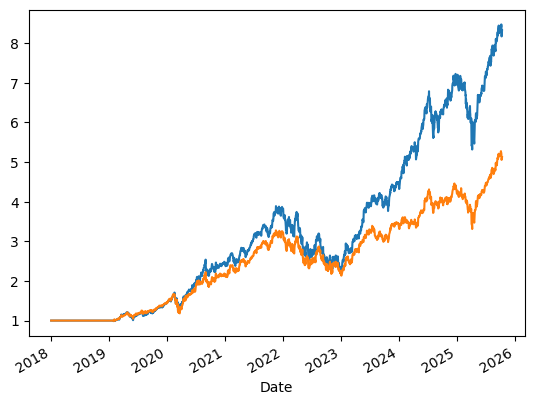

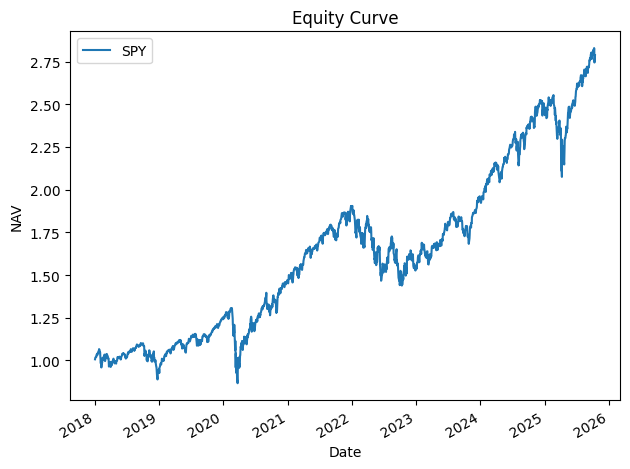

In [33]:

# Equity curves
plt.figure()
(bt_eq["equity"]).plot(label="Equal-Weight")
(bt_minv["equity"]).plot(label="Min-Variance")
((1 + bench_ret).cumprod()).plot(label="SPY")
plt.legend()
plt.title("Equity Curve")
plt.xlabel("Date"); plt.ylabel("NAV")
plt.tight_layout()
plt.show()


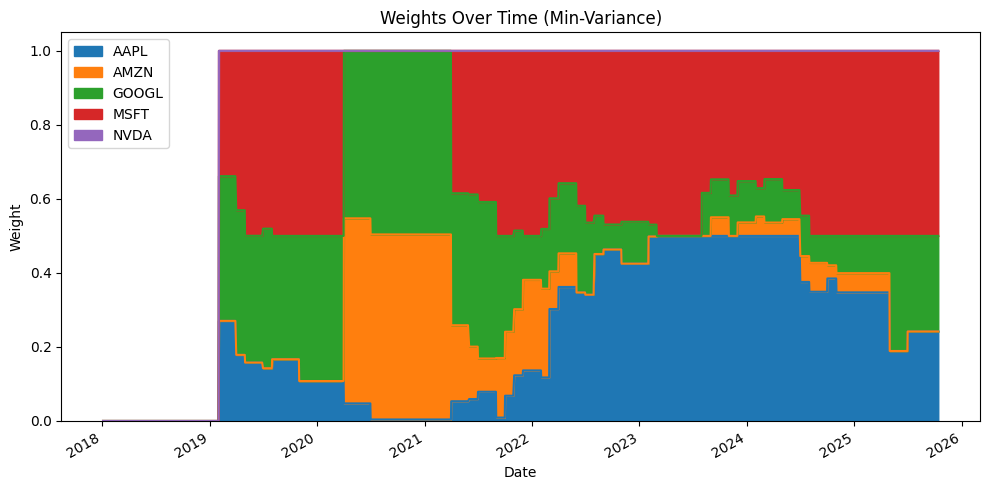

In [34]:

# Weight evolution (stacked area) for Min-Variance
ax = bt_minv["weights"].plot.area(figsize=(10,5))
ax.set_title("Weights Over Time (Min-Variance)")
ax.set_xlabel("Date"); ax.set_ylabel("Weight")
plt.tight_layout()
plt.show()


## Export Results

In [35]:

Path("results").mkdir(exist_ok=True)
summary.to_csv("results/summary.csv")
bt_eq["equity"].to_csv("results/equity_equal.csv")
bt_minv["equity"].to_csv("results/equity_minvar.csv")
bt_eq["weights"].to_csv("results/weights_equal.csv")
bt_minv["weights"].to_csv("results/weights_minvar.csv")
print("Saved CSVs in results/ folder.")


Saved CSVs in results/ folder.



## Next Steps / Extensions
- Add **Ledoit-Wolf** shrinkage for covariance (`sklearn.covariance.LedoitWolf`) to stabilize min-variance.
- Implement and compare **Max-Sharpe** (function `max_sharpe_weights` already provided).
- Add **sector caps** (e.g., Technology ≤ 80%) by introducing linear constraints in the optimizer.
- Build a small **Streamlit** app for interactive controls (tickers, frequency, thresholds).
